# Setup 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['TeX Gyre Termes'],'size':10.0})
rc('axes',**{'labelsize':'large'})
rc('text', usetex=False)
rc('figure', figsize=(4,3))
rc('mathtext', fontset='stix')
rc('pdf',**{'fonttype': 42})

In [3]:
from cycler import cycler
linestyle_cycler = cycler('linestyle', ['-', '--', ':', '-.'])

In [4]:
from scipy import constants, optimize, interpolate, stats

In [5]:
def read_xvg(filename):
    '''A little auxiliary function to read a GROMACS-produced XVG
    file, automatially skipping over the default xmgr formatting.'''
    
    skiplines = 0
    with open(filename, 'rt') as xvgfile:
        for line in xvgfile:
            if line[0] in ('#','@'):
                skiplines += 1
                continue
            else:
                break
            
    return np.loadtxt(filename, skiprows=skiplines)

# Energy analysis 

We see to answer whether each simulation is consistent with $\left<E_K\right> = (3/2)RT$ (where $E_K$ is kinetic energy) and how consistent each simulation is with respect to the ideal gas law $P\left<V\right>=nR\left<T\right>$. The volume is determined from the size of the periodic box containing the simulation, and GROMACS reports average kinetic energy, pressure, and temperature. This information is reported in the simulation output files (`*.log`), but here we do the average ourselves.

In [6]:
# expected order:
# time, LJ, potential, kinetic, total E, temperature, pressure
# energies are kJ/(mol of simulations)
# temperature is Kelvin
# pressure is bar

# The last line of a gro file contains the box vectors, in nm
# Brute-force read the last line, convert to float, and get the volume in L
DM_PER_NM = 1e-8
box_vectors = np.fromiter([float(v) for v in open('ideal_100.gro','rt')
                           .readlines()[-1].strip().split()], dtype=np.float32)
volume = (box_vectors*DM_PER_NM).prod()

R_kJ = constants.R / 1000.0  #kJ/mol.K
R_barL = R_kJ * 10 # bar.L/mol.K

n = 100 / constants.Avogadro


print('System volume is {} L'.format(volume))
print('Number of moles = {}'.format(n))
print()

print('{:6s}  {:11s}  {:7s}  {:15s}  {:21s}'
      .format('Type', 'Ideal T (K)', '<T> (K)', 
              'Rel. Err. in KE', 'Rel. Err in PV vs nRT'))
averages = {}
for interaction_type in ('ideal', 'real'):
    averages[interaction_type] = {}
    for temperature in (100, 200, 300):

        energy_filename = 'energy_{}_{}.xvg'.format(temperature,interaction_type)
        energy_data = read_xvg(energy_filename)
        
        avg_kinetic = energy_data[:,3].mean() / 100 # per atom
        avg_pressure = energy_data[:,6].mean()
        avg_temp = energy_data[:,5].mean()
        
        averages[interaction_type][temperature] = {'kinetic': avg_kinetic,
                                                   'pressure': avg_pressure,
                                                   'temperature': avg_temp}
        
        # KE = (3/2)RT
        pred_avg_kinetic = 1.5*R_kJ*avg_temp
        
        avg_kin_error = (avg_kinetic - pred_avg_kinetic)/pred_avg_kinetic
        
        # PV = nRT
        PV = avg_pressure * volume
        nRT = n*R_barL*avg_temp
        
        ideality_error = (PV-nRT)/nRT
        
        print('{:6s}  {:11d}  {:7.3f}  {:15.8e}  {:21.8e}'
              .format(interaction_type, temperature, avg_temp,
                      avg_kin_error, ideality_error))
        

System volume is 4.431409095683481e-22 L
Number of moles = 1.6605390404271642e-22

Type    Ideal T (K)  <T> (K)  Rel. Err. in KE  Rel. Err in PV vs nRT
ideal           100   97.868   2.84544522e-07         3.67975291e-07
ideal           200  192.966   2.69049780e-07         1.90408991e-07
ideal           300  295.378   2.35263416e-07         2.64528930e-07
real            100   98.823   2.82159795e-07        -6.41930145e-02
real            200  195.240   2.82124694e-07        -1.94872316e-02
real            300  294.333   2.82090661e-07        -5.97672517e-03


All simulations are consistent with $\left<E_K\right> = (3/2)RT$, with an error of roughly $10^{-5}\%$ (which is on the order of the storage accuracy of the single-precision floating-point format GROMACS uses to store energies). The ideal gas simulations are, as expected, consistent with the ideal gas law, again with an error of roughly $10^{-5}\%$. The real gas simulations show negative deviations from the ideal gas law of around 7% for 100 K, 2% at 200 K, and 0.5% at 300 K. As expected, at low density, attractive forces dominate, and these attractive forces become progressively less important as temperature increases.

# RDF Analysis

In [7]:
rdf_data = {}
for interaction_type in ('ideal', 'real'):
    rdf_data[interaction_type] = {}
    for temperature in (100, 200, 300):
        rdf_filename = 'rdf_{}_{}.xvg'.format(temperature,interaction_type)
        rdf_data[interaction_type][temperature] = read_xvg(rdf_filename)

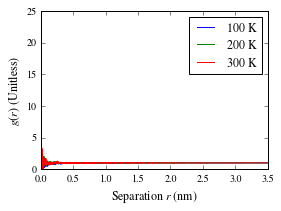

In [8]:
for temperature in (100, 200, 300):
    this_rdf_data = rdf_data['ideal'][temperature]
    plot(this_rdf_data[:,0], this_rdf_data[:,1], label='{} K'.format(temperature))
    xlabel('Separation $r$ (nm)')
    ylabel('$g(r)$ (Unitless)')
    
xlim(0,3.5)
legend(loc='best')
tight_layout()
savefig('rdfs_ideal.pdf')

As separation decreases, noise increases, but otherwise $g(r) = 1$ for an ideal gas at all temperatures, as we expect from the definition of $g(r)$.

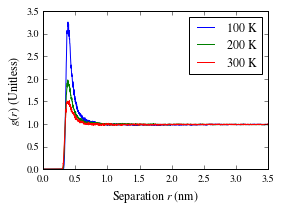

In [9]:
for temperature in (100, 200, 300):
    this_rdf_data = rdf_data['real'][temperature]
    plot(this_rdf_data[:,0], this_rdf_data[:,1], label='{} K'.format(temperature))
    xlabel('Separation $r$ (nm)')
    ylabel('$g(r)$ (Unitless)')
    
xlim(0,3.5)
legend(loc='best')
tight_layout()
savefig('rdfs_real_fullrange.pdf')

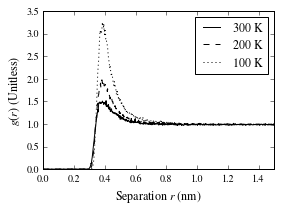

In [10]:
gca().set_prop_cycle(linestyle_cycler)
for temperature in (300, 200, 100):
    this_rdf_data = rdf_data['real'][temperature]
    plot(this_rdf_data[:,0], this_rdf_data[:,1], label='{} K'.format(temperature), color='black')
    xlabel('Separation $r$ (nm)')
    ylabel('$g(r)$ (Unitless)')
    
xlim(0,1.5)
legend(loc='best')
tight_layout()
savefig('rdfs_real.pdf')

As we expect, distant particles do not interact with each other, there is a single small separation favored over all others (the dimer internuclear separation), and the probability of dimerization decreases with increasing temperature.

# Pair potential analysis

/opt/apps/anaconda/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


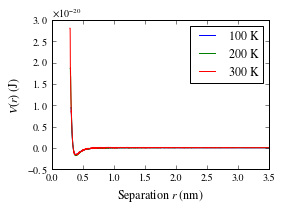

In [11]:
gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
for temperature in (100, 200, 300):
    this_rdf_data = rdf_data['real'][temperature]
    true_avg_temp = averages['real'][temperature]['temperature']
    V = -constants.Boltzmann * true_avg_temp * np.log(this_rdf_data[:,1])
    plot(this_rdf_data[:,0], V, label='{} K'.format(temperature))
    xlabel('Separation $r$ (nm)')
    ylabel('$V(r)$ (J)')
    
xlim(0,3.5)
legend(loc='best')
tight_layout()

/opt/apps/anaconda/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


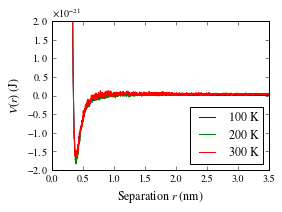

In [12]:
gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
for temperature in (100, 200, 300):
    this_rdf_data = rdf_data['real'][temperature]
    true_avg_temp = averages['real'][temperature]['temperature']
    V = -constants.Boltzmann * true_avg_temp * np.log(this_rdf_data[:,1])
    plot(this_rdf_data[:,0], V, label='{} K'.format(temperature))
    xlabel('Separation $r$ (nm)')
    ylabel('$V(r)$ (J)')
    
xlim(0,3.5)
ylim(-0.2e-20,0.2e-20)
legend(loc='best')
tight_layout()

As expected, the pair potentials are equal at all temperatures, though it appears noise increases as temperature increases. The 100 K pair potential will be used in the following.

/opt/apps/anaconda/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


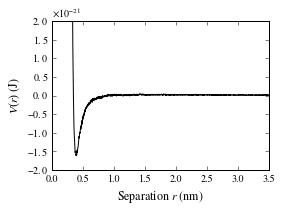

In [13]:
gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
temperature = 100
this_rdf_data = rdf_data['real'][temperature]
true_avg_temp = averages['real'][temperature]['temperature']
V = -constants.Boltzmann * true_avg_temp * np.log(this_rdf_data[:,1])
plot(this_rdf_data[:,0], V, label='{} K'.format(temperature),color='black')
xlabel('Separation $r$ (nm)')
ylabel('$V(r)$ (J)')
    
xlim(0,3.5)
ylim(-0.2e-20,0.2e-20)
tight_layout()

##  Linearized fit

In [14]:
# this_rdf_data, temperature, true_avg_temp, V all set above
r = this_rdf_data[:,0]
x = r**(-6.0)

/opt/apps/anaconda/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


We need the long-distance (small $1/r^6$) tail of the $V(r)$ curve. Let's plot $V(r) vs 1/r^6$ and see where it is approximately linear.

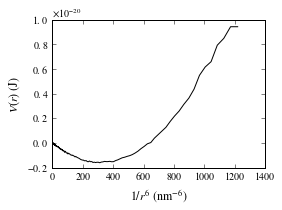

In [15]:
gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
plot(x, V, color='black')
xlabel('$1/r^6$ (nm$^{-6}$)')
ylabel('$V(r)$ (J)')
tight_layout()

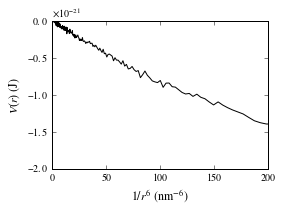

In [16]:
gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
plot(x, V, color='black')
xlabel('$1/r^6$ (nm$^{-6}$)')
ylabel('$V(r)$ (J)')
xlim(0,200)
ylim(-2e-21,0)
tight_layout()

To the left of $1/r^6 \approx 100$ looks promising.

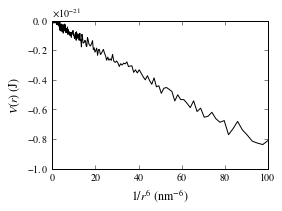

In [17]:
gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
plot(x, V, color='black')
xlabel('$1/r^6$ (nm$^{-6}$)')
ylabel('$V(r)$ (J)')
xlim(0,100)
ylim(-1e-21,0)
tight_layout()

In [18]:
stats.linregress(x[x<50],V[x<50])

LinregressResult(slope=-9.780988485935501e-24, intercept=1.6820123472622062e-23, rvalue=-0.98277754630979819, pvalue=0.0, stderr=4.5637202888787002e-26)

## Direct fit 

In [19]:
Vfit = (lambda r, C: -C/r**6)

In [32]:
cutoff = 0.5 # twice the r value of the minimum
mask = r > cutoff
p, covar = optimize.curve_fit(Vfit, r[mask], V[mask])
C = p[0]
errC = covar[0,0]**0.5
print('C = {} ± {}'.format(C, errC))

C = 8.992923450595522e-24 ± 6.445551675425954e-26


/opt/apps/anaconda/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(-2e-21, 1e-22)

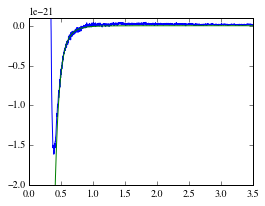

In [33]:
plot(r,V, label='Observed')
plot(r,Vfit(r,C))
xlim(0,3.5)
ylim(-2e-21,1e-22)

/opt/apps/anaconda/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(-2e-21, 1e-22)

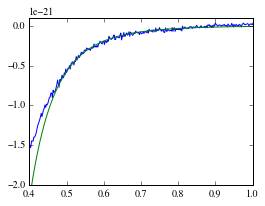

In [34]:
plot(r,V, label='Observed')
plot(r,Vfit(r,C))
xlim(0.4,1.0)
ylim(-2e-21,1e-22)

## Cheater's method 

This force field uses the Lennard-Jones 6-12 potential for nonbonded interactions, so we can fit to the Lennard Jones potential 
$$
V(r) = \frac{C_{12}}{r^{12}} - \frac{C_6}{r^6}
$$
and expect very good results.

In [23]:
def lj_potential(r,C6,C12):
    return C12/r**12 - C6/r**6

In [24]:
cutoff = 0.34
mask = r > cutoff
p, covar = optimize.curve_fit(lj_potential, r[mask], V[mask])
print(p)
print(covar**0.5)

[  9.90482048e-24   1.55614554e-26]
[[  2.30138415e-26   1.06161794e-27]
 [  1.06161794e-27   5.23375814e-29]]


This gives $C_6 = (1.0600 \pm 0.0017)\times 10^{-23}$

/opt/apps/anaconda/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/opt/apps/anaconda/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app


(-2e-21, 1e-22)

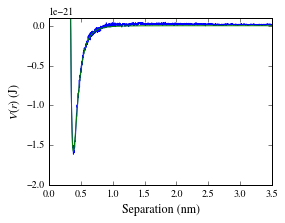

In [25]:
plot(r,V)
plot(r, lj_potential(r,*p))
xlabel('Separation (nm)')
ylabel('$V(r)$ (J)')
xlim(0,3.5)
ylim(-2e-21,1e-22)

## Calculation of the van der Waals constants $a$ and $b$ 

We need to find where $V(r)$ crosses the $x$ axis. Looks to be in the neighborhood of 0.34 nm.

(-2e-21, 2e-21)

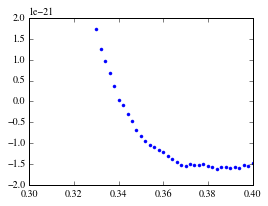

In [26]:
plot(r,V,linestyle=' ',marker='.')
xlim(0.3,0.4)
ylim(-2e-21,2e-21)

We'll use a linear interpolator to get the best estimate possible from our data. This is also likely what one would do with a spreadsheet: start by finding the two $r$ values where $V$ brackets zero, then interpolate to zero.

In [35]:
Vinterp = interpolate.interp1d(r, V)
sigma = optimize.fsolve(Vinterp, 0.34)[0]
print(sigma)

0.340500025647


In [36]:
isigma = np.searchsorted(r,sigma)
print(r[isigma-1:isigma+1])
print(V[isigma-1:isigma+1])
err_sigma = r[isigma] - r[isigma-1]
print(err_sigma)

[ 0.34   0.342]
[  2.47829460e-23  -7.43437534e-23]
0.002


In [37]:
# Convert from J.nm^6 to bar.L.nm^6
C_barL = C / 100.0

# Convert sigma from nm to dm, so that it becomes L when we cube it
sigma_dm = sigma*1e-8
err_sigma_dm = err_sigma*1e-8

In [38]:
a = 2*pi *C_barL*1e-48*constants.Avogadro**2/(3*sigma_dm**3)
err_a = a*errC/C + a*err_sigma_dm/sigma_dm
print('a = {:.2f} ± {:.2f} L^2 bar/mol^2'.format(a, err_a))

a = 1.73 ± 0.02 L^2 bar/mol^2


In [39]:
b = 2*pi*sigma_dm**3 * constants.Avogadro/3
err_b = 2*pi*constants.Avogadro*sigma_dm**2*err_sigma_dm
print('b = {:.4f} ± {:.4f} L/mol'.format(b,err_b))

b = 0.0498 ± 0.0009 L/mol
